In [1]:
import tensorflow as tf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import gym
from gym import spaces
from gym.utils import seeding

import numpy as np
from ads_utils import load_data, plot

In [2]:
print(tf.__version__)

'''Requires this version of tensorflow. I may checkout stable_baselines3 
(as it seems to integrate with pytorch instead)'''

1.15.0


'Requires this version of tensorflow. I may checkout stable_baselines3 \n(as it seems to integrate with pytorch instead)'

Using stable_baselines with our data. May need a lot of refactoring.

#### LIST OF METHODS
__init__:
- action_space 
- observation_space

step:
- returns observation, reward, done, info
- observation: 

reset:
- "reset" everything in the environment, eg. balance = INITIAL_BALANCE
- returns the next observation_space


https://github.com/notadamking/Stock-Trading-Environment/blob/master/env/StockTradingEnv.py
The code follows some of this implementation. 


In [10]:
type(True)

bool

In [23]:
done = -1 <= 0 or 8 > 0

In [24]:
type(done)

bool

In [25]:
done

True

In [30]:
SELL, HOLD, BUY = -1, 0, 1
INITIAL_BALANCE = 1000
MAX_ACCOUNT_BALANCE = 2147483647
PRICES = 0
POSITION = 1
BALANCE = 2


class Environment(gym.Env):  
    # required for stable baselines 
    metadata = {'render.modes': ['human']}
    
    def __init__(self, data, balance, transaction_cost=0.001, i=0, position=0):
        self.current_step = 5  
        
        self.done = False
        self.data = data
        self.position = 0 
        self.transaction_cost = transaction_cost
        
        self._seed()
        
        # Sell, Hold, Buy == 0, 1, 2 
        self.action_space = spaces.Discrete(3)

        '''
        What do you want the agent to observe?
        - closing prices of the last x=5 days
        - current timestep's closing price
        - current balance 
        - current portfolio value
        TOTAL: shape = (8, )
        * the values are in [0, inf]'''
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (8, ))
        
    def _next_observation(self):        
        '''Getting the next observation'''
        
        frame = np.array(data.loc[self.current_step - 5: self.current_step, "close"].values)
        
        obs = np.append(frame, [self.balance ,
                                 self.portfolio_value], axis=0)

        return obs

    def _take_action(self, action):
        curr_price = self.data.loc[self.current_step, "close"]
        
        # Transforms SELL, HOLD, BUY to -1, 0, 1
        # action = act - 1 
        
        # Perform position transition
        self.balance -= curr_price*abs(action - self.position)*self.transaction_cost
        
        # A Buy
        if (action == BUY and self.position == HOLD) or (action == HOLD and self.position == SELL):
            self.balance -= curr_price
            self.shares_held += 1
        
        # A Sell
        elif (action == SELL and self.position == HOLD) or (action == HOLD and self.position == BUY):
            self.balance += curr_price
            self.shares_held -= 1
            
        # Flip Position
        elif abs(action - self.position) == 2:
            self.balance -= 2 * action * curr_price
            self.shares_held -= 2 * action
        
        
    def step(self, act):
        ''' Updates environment with action taken, returns new state and reward from state transition '''
        
        prior_portfolio_value = self.get_portfolio_value()
        
        # Transforms SELL, HOLD, BUY to -1, 0, 1
        action = act - 1 
        self._take_action(action)
        
        # the change in portfolio value
        reward = self.get_portfolio_value() - prior_portfolio_value     
        
        # current portfolio value
        self.portfolio_value = self.get_portfolio_value()
        
        # Update historical data
        self.current_step += 1
        self.position = action
        
        # no more money
        if self.balance <= 0 or self.portfolio_value <= 0:
            self.done = True
        
        obs = self._next_observation()
        
        # require to return: observation, reward, done, info
        print(self.balance, self.portfolio_value)
        print(obs)
        
        print(type(self.done))
        return obs, reward, self.done, {}
    
    
    def get_portfolio_value(self):
        ''' Returns current portfolio value '''
        curr_price = self.data.loc[self.current_step, "close"]
        
        if self.position == BUY:
            return self.balance + curr_price
        
        elif self.position == SELL:
            return self.balance - curr_price
        
        return self.balance
    
    
    
    def reset(self):
        '''Reset everything as if we just started (for a new episode)'''
        self.position = 0
        self.balance = INITIAL_BALANCE
        self.net_worth = INITIAL_BALANCE
        self.max_net_worth = INITIAL_BALANCE
        self.portfolio_value = self.balance
        self.shares_held = 0
        self.done = False
        
        obs = self._next_observation()   
        #print("reset",obs)
        
        return obs

    def save_portfolio(self, mode='human'):
        with open('output.csv', 'a') as file:
            file.write(f'{self.current_step},{self.portfolio_value},{self.balance}\n')
        return
    
    
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
            
        
'''NOTE: there is no train/test split yet'''            
data = load_data([2])

env = Environment(data, INITIAL_BALANCE)
print(env)

<Environment instance>


Balance, Portfolio_value may go to negative, hence this error :(
- TODO: find out how to "restrict" these

In [31]:
from stable_baselines.common.env_checker import check_env

env_check = Environment(data, INITIAL_BALANCE)
# It will check your custom environment and output additional warnings if needed
check_env(env_check)

4027.969 4027.969
[3020.    3026.83  3024.88  3030.46  3031.    3030.9   4027.969 4027.969]
<class 'bool'>
994.0380999999998 -2036.8619000000003
[ 3026.83    3024.88    3030.46    3031.      3030.9     3031.5
   994.0381 -2036.8619]
<class 'bool'>
-2034.5315 -2034.5315
[ 3024.88    3030.46    3031.      3030.9     3031.5     3030.
 -2034.5315 -2034.5315]
<class 'bool'>
1000.0 1000.0
[3030.46 3031.   3030.9  3031.5  3030.   3027.9  1000.   1000.  ]
<class 'bool'>
1000.0 1000.0
[3031.  3030.9 3031.5 3030.  3027.9 3027.9 1000.  1000. ]
<class 'bool'>
4024.8721 4024.8721
[3030.9    3031.5    3030.     3027.9    3027.9    3025.51   4024.8721
 4024.8721]
<class 'bool'>
-2032.1989200000003 -5057.708920000001
[ 3031.5      3030.       3027.9      3027.9      3025.51     3027.15
 -2032.19892 -5057.70892]
<class 'bool'>
4024.12285 4024.12285
[3030.      3027.9     3027.9     3025.51    3027.15    3028.29
 4024.12285 4024.12285]
<class 'bool'>
-2038.5137299999997 -5066.80373
[ 3027.9      3027.9 

The model used is PPO2 

#### Short excerpt from docs: 
The Proximal Policy Optimization (PPO) algorithm combines ideas from A2C (having multiple workers) and TRPO (it uses a trust region to improve the actor).

#### Link to doc:
https://stable-baselines.readthedocs.io/en/master/modules/ppo2.html

* there's other actor-critic based models to implement as well


PS: I have yet to know how to interpret the results below

In [182]:
from stable_baselines import PPO2
from stable_baselines.common.policies import MlpPolicy

model = PPO2(MlpPolicy, env, verbose=1)


model.learn(total_timesteps=1000) 

Wrapping the env in a DummyVecEnv.
---------------------------------------
| approxkl           | 7.813419e-06   |
| clipfrac           | 0.0            |
| explained_variance | 6.1e-05        |
| fps                | 243            |
| n_updates          | 1              |
| policy_entropy     | 1.0985768      |
| policy_loss        | -0.00090344483 |
| serial_timesteps   | 128            |
| time_elapsed       | 1.69e-05       |
| total_timesteps    | 128            |
| value_loss         | 20916294.0     |
---------------------------------------
--------------------------------------
| approxkl           | 0.00011775278 |
| clipfrac           | 0.0           |
| explained_variance | -5.96e-06     |
| fps                | 623           |
| n_updates          | 2             |
| policy_entropy     | 1.0982988     |
| policy_loss        | -0.004415312  |
| serial_timesteps   | 256           |
| time_elapsed       | 0.526         |
| total_timesteps    | 256           |
| value_loss    

In [183]:
obs = env.reset()
#env = Environment(test_data, INITIAL_BALANCE)

prices = []
rewards = []
actions = []
for i in range(200):
    action, _states = model.predict(obs)
    
    obs, reward, done, _ = env.step(action)
    
    actions.append(action)
    rewards.append(reward)

    prices.append(obs[5]) # current timestep's closing price
    env.save_portfolio()

In [184]:
rewards

[-3078.075,
 3072.25467,
 -3078.82575,
 0.0,
 3070.834092,
 -3076.8920182,
 0.0,
 0.0,
 -3080.1120349999997,
 3073.95297,
 3071.4554700000003,
 3070.8261,
 0.0,
 3070.793133,
 -3079.0214454999996,
 0.0,
 0.0,
 0.0,
 3063.691242,
 0.0,
 0.0,
 0.0,
 3065.0319,
 3065.926005000001,
 0.0,
 3067.4195099999997,
 -3074.861789999999,
 -3075.1249528999997,
 0.0,
 3072.6842400000005,
 0.0,
 -3082.48941,
 0.0,
 -3086.9838999999993,
 0.0,
 3074.9220000000005,
 0.0,
 3077.169749999999,
 3080.985929999999,
 -3085.1958137,
 3076.939980000001,
 3079.8820349999987,
 3076.2157050000023,
 3073.9314914999995,
 0.0,
 0.0,
 3073.393530000001,
 0.0,
 3073.523399999998,
 3073.364259300004,
 0.0,
 3071.0558699999965,
 3071.3705550000013,
 3070.3565700000036,
 0.0,
 3073.5833400000047,
 -3078.074999999997,
 3064.9320000000007,
 3062.7096246,
 0.0,
 3059.460177300003,
 -3058.0394844999973,
 3054.9420000000027,
 0.0,
 0.0,
 3056.6003399999972,
 -3059.286230000005,
 3053.88306,
 0.0,
 3047.689259999999,
 -3057.7046

In [185]:
portfolio = pd.read_csv("output.csv", header=None, names=["index", "portfolio", "balance"])

In [186]:
portfolio.tail(10)

,index,portfolio,balance
190,1087,110182.35718,110182.35718
191,1088,110182.35718,110182.35718
192,1089,113392.64368,113392.64368
193,1090,116599.43368,116599.43368
194,1091,119801.22868,119801.22868
195,1092,123003.53317,123003.53317
196,1093,123003.53317,123003.53317
197,1094,126210.32317,126210.32317
198,1095,126210.32317,126210.32317
199,1096,126210.32317,126210.32317


In [187]:
# actions were 0, 1, 2 (to integrate with stable_baselines)
# this changes it back to target_actions

target_actions = []
for a in actions:
    if a == 0:
        target_actions.append(-1)
    elif a == 1:
        target_actions.append(0)
    else:
        target_actions.append(1)

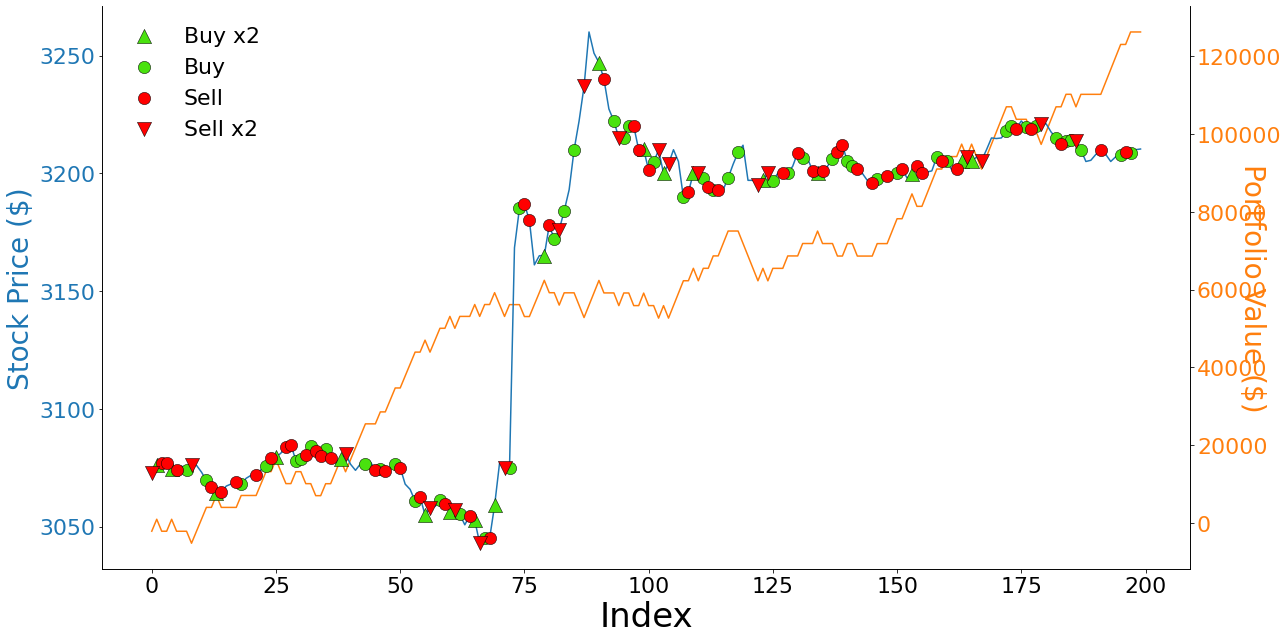

In [188]:
plot(prices, target_actions, portfolio.portfolio)


- sometimes, the portfolio values goes to negative :O 